# Intro to the problem

Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.

Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data - including telco and transactional information - to predict their clients' repayment abilities.

We use this dataset to build a startup - **risk evaluation as a service**. We are not yet sure, what is the most crucial problem for our potential clients, so we had a meeting with my friend to discuss how your **proof-of-concept (POC)** product should look like.

After a lot of arguing, we both agreed to **create a number of different models** so that we have a robust and diversified offering when we get your first meeting with the potential clients. We are eager to investigate the dataset and see what we can predict, so I propose that I **come up with interesting features to analyze and predict** - this way, I'll focus on building a solid offering, and she can work on getting meetings with the banks.

# Imports and set up

In [1]:
# My own helper package
from edawesome.eda import EDA
from edawesome.sns_help import corr_heatmap, kde_boxen_qq
from edawesome.str_help import snake_to_title

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark
import scipy.stats as st

from pyspark.sql.functions import col, count, lit

from IPython.display import Image

import featuretools as ft
import pickle

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
SEED = 42

In [4]:
eda = EDA(
    data_dir_path='/home/dreamtim/Desktop/Coding/turing-ds/MachineLearning/tiryko-ML1.4/data',
    archives=['/home/dreamtim//Downloads/home-credit-default-risk.zip'],
    use_pyspark=True,
    pandas_mem_limit=1024**2,
    pyspark_mem_limit='4g'   
)

In [5]:
eda.load_data()

# Loading data

patool: Extracting /home/dreamtim//Downloads/home-credit-default-risk.zip ...
patool: running /usr/bin/7z x -o/home/dreamtim/Desktop/Coding/turing-ds/MachineLearning/tiryko-ML1.4/data -- /home/dreamtim//Downloads/home-credit-default-risk.zip
patool: ... /home/dreamtim//Downloads/home-credit-default-risk.zip extracted to `/home/dreamtim/Desktop/Coding/turing-ds/MachineLearning/tiryko-ML1.4/data'.


### homecredit_columns_description

,index,table,row,description,special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN


,index,table,row,description,special
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN
218,221,installments_payments.csv,AMT_PAYMENT,What the client actually paid on previous cred...,NaN


**219 rows × 5 columns**

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/09 12:53:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### pos_cash_balance

,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


,sk_id_prev,sk_id_curr,months_balance,cnt_instalment,cnt_instalment_future,name_contract_status,sk_dpd,sk_dpd_def
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0
10001357,1259607,174278,-52,16.0,0.0,Completed,0,0


**10,001,358 rows × 8 columns**

### application_test

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,None,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,None,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,None,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary spec

,sk_id_curr,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
48739,456221,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,270000.0,Unaccompanied,Working,Secondary / secondary special,Widow,House / apartment,0.002042,-19970,-5169,-9094.0,-3399,NaN,1,1,1,1,1,0,None,1.0,3,3,WEDNESDAY,16,0,0,0,0,0,0,Other,NaN,0.648575,0.643026,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,1.0,0.0,1.0,0.0,-684.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
48740,456222,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,495000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.035792,-11186,-1149,-3015.0,-3003,NaN,1,1,0,1,0,0,Sales staff,4.0,2,2,MONDAY,11,0,0,0,0,1,1,Trade: type 7,NaN,0.684596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,None,None,2.0,0.0,2.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
48741,456223,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,315000.0,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.026392,-15922,-3037,-2681.0,-1504,4.0,1,1,0,1,1,0,None,3.0,2,2,WEDNESDAY,12,0,0,0,0,0,0,Business Entity Type 3,0.733503,0.632770,0.283712,0.1113,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1383,NaN,0.0542,0.1134,0.1415,0.9955,NaN,NaN,0.1611,0.1379,0.3333,NaN,NaN,NaN,0.1441,NaN,0.0574,0.1124,0.1364,0.9955,NaN,NaN,0.16,0.1379,0.3333,NaN,NaN,NaN,0.1408,NaN,0.0554,None,block of flats,0.1663,"Stone, brick",No,0.0,0.0,0.0,0.0,-838.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0
48742,456224,Cash loans,M,N,N,0,225000.0

**48,744 rows × 121 columns**

### application_train

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,name_type_suite,name_income_type,name_education_type,name_family_status,name_housing_type,region_population_relative,days_birth,days_employed,days_registration,days_id_publish,own_car_age,flag_mobil,flag_emp_phone,flag_work_phone,flag_cont_mobile,flag_phone,flag_email,occupation_type,cnt_fam_members,region_rating_client,region_rating_client_w_city,weekday_appr_process_start,hour_appr_process_start,reg_region_not_live_region,reg_region_not_work_region,live_region_not_work_region,reg_city_not_live_city,reg_city_not_work_city,live_city_not_work_city,organization_type,ext_source_1,ext_source_2,ext_source_3,apartments_avg,basementarea_avg,years_beginexpluatation_avg,years_build_avg,commonarea_avg,elevators_avg,entrances_avg,floorsmax_avg,floorsmin_avg,landarea_avg,livingapartments_avg,livingarea_avg,nonlivingapartments_avg,nonlivingarea_avg,apartments_mode,basementarea_mode,years_beginexpluatation_mode,years_build_mode,commonarea_mode,elevators_mode,entrances_mode,floorsmax_mode,floorsmin_mode,landarea_mode,livingapartments_mode,livingarea_mode,nonlivingapartments_mode,nonlivingarea_mode,apartments_medi,basementarea_medi,years_beginexpluatation_medi,years_build_medi,commonarea_medi,elevators_medi,entrances_medi,floorsmax_medi,floorsmin_medi,landarea_medi,livingapartments_medi,livingarea_medi,nonlivingapartments_medi,nonlivingarea_medi,fondkapremont_mode,housetype_mode,totalarea_mode,wallsmaterial_mode,emergencystate_mode,obs_30_cnt_social_circle,def_30_cnt_social_circle,obs_60_cnt_social_circle,def_60_cnt_social_circle,days_last_phone_change,flag_document_2,flag_document_3,flag_document_4,flag_document_5,flag_document_6,flag_document_7,flag_document_8,flag_document_9,flag_document_10,flag_document_11,flag_document_12,flag_document_13,flag_document_14,flag_document_15,flag_document_16,flag_document_17,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,225000.0,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982,NaN,1,1,0,1,0,0,Sales staff,1.0,1,1,THURSDAY,15,0,0,0,0,0,0,Services,0.145570,0.681632,NaN,0.2021,0.0887,0.9876,0.8300,0.0202,0.22,0.1034,0.6042,0.2708,0.0594,0.1484,0.1965,0.0753,0.1095,0.1008,0.0172,0.9782,0.7125,0.0172,0.0806,0.0345,0.4583,0.0417,0.0094,0.0882,0.0853,0.0,0.0125,0.2040,0.0887,0.9876,0.8323,0.0203,0.22,0.1034,0.6042,0.2708,0.0605,0.1509,0.2001,0.0757,0.1118,reg oper account,block of flats,0.2898,"Stone, brick",No,0.0,0.0,0.0,0.0,-273.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,225000.0,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090,NaN,1,0,0,1,1,0,None,1.0,2,2,MONDAY,8,0,0,0,0,0,0,XNA,NaN,0.115992,NaN,0.0247,0.0435,0.9727,0.6260,0.0022,0.00,0.1034,0.0833,0.1250,0.0579,0.0202,0.0257,0.0000,0.0000,0.0252,0.0451,0.9727,0.6406,0.0022,0.0000,0.1034,0.0833,0.1250,0.0592,0.0220,0.0267,0.0,0.0000,0.0250,0.0435,0.9727,0.6310,0.0022,0.00,0.1034,0.0833,0.1250,0.0589,0.0205,0.0261,0.0000,0.0000,reg oper account,block of flats,0.0214,"Stone, brick",No,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,585000.0,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150,NaN,1,1,0,1,0,1,Managers,1.0,3,3,THURSDAY,9,0,0,0,0,1,1,School,0.744026,0.535722,0.218859,0.1031,0.0862,0.9816,0.7484,0.0123,0.00,0.2069,0.1667,0.2083,NaN,0.0841,0.9279,0.0000,0.0000,0.1050,0.0894,0.9816,0.7583,0.0124,0.0000,0.2069,0.1667,0.

**307,511 rows × 122 columns**

### bureau

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN
1716427,246829,5057778,Closed,currency 1,-463,0,NaN,-387.0,NaN,0,22500.00,0.0,NaN,0.0,Microloan,-387,NaN


**1,716,428 rows × 17 columns**

### bureau_balance

,sk_id_bureau,months_balance,status
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


,sk_id_bureau,months_balance,status
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X
27299924,5041336,-51,X


**27,299,925 rows × 3 columns**

### credit_card_balance

,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,amt_payment_current,amt_payment_total_current,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


,sk_id_prev,sk_id_curr,months_balance,amt_balance,amt_credit_limit_actual,amt_drawings_atm_current,amt_drawings_current,amt_drawings_other_current,amt_drawings_pos_current,amt_inst_min_regularity,amt_payment_current,amt_payment_total_current,amt_receivable_principal,amt_recivable,amt_total_receivable,cnt_drawings_atm_current,cnt_drawings_current,cnt_drawings_other_current,cnt_drawings_pos_current,cnt_instalment_mature_cum,name_contract_status,sk_dpd,sk_dpd_def
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.0,NaN,0.000,0.00,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.0,1879.11,0.000,0.00,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.0,375750.00,356994.675,269356.14,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.0,NaN,0.000,0.00,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840311,2411345,236760,-10,0.000,157500,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.00,0.000,0.000,0.0,0,0.0,0.0,21.0,Completed,0,0


**3,840,312 rows × 23 columns**

### installments_payments

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN
13605400,2448869,434321,1.0,19,-27.0,NaN,11504.250,NaN


**13,605,401 rows × 8 columns**

### previous_application

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,None,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,None,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,None,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,flag_last_appl_per_contract,nflag_last_appl_in_day,rate_down_payment,rate_interest_primary,rate_interest_privileged,name_cash_loan_purpose,name_contract_status,days_decision,name_payment_type,code_reject_reason,name_type_suite,name_client_type,name_goods_category,name_portfolio,name_product_type,channel_type,sellerplace_area,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,None,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0
1670213,2418762,261212,Cash loans,16431.300,360000.0,360000.0,NaN,360000.0,SUNDAY,10,Y,1,NaN,NaN,NaN,XNA,Approved,-1193,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,48.0,middle,Cash X-Sell: middle,365243.0,-1163.0,247.0,-443.0,-423.0,0.0


**1,670,214 rows × 37 columns**

### sample_submission

,sk_id_curr,target
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


,sk_id_curr,target
48739,456221,0.5
48740,456222,0.5
48741,456223,0.5
48742,456224,0.5
48743,456250,0.5


**48,744 rows × 2 columns**

**Loaded 10 dataframes**

**To add dataframes, use `add_df` method**

**After data loading is completed, call `eda.next()`**

In [6]:
eda.next()

### EDA is in loaded state now

Now you can drop or impute missing values. Here are some useful methods:
- `clean_check` - check number for missing values in each column
- `drop_empty_columns` -  drop columns with a lot of missing values
- `clean` - drop duplicates and missing values (deprecated)

In [7]:
eda.clean_check()

# Check for bad values

### Nulls and datatypes in homecredit_columns_description

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        219 non-null    int64 
 1   table        219 non-null    object
 2   row          219 non-null    object
 3   description  219 non-null    object
 4   special      86 non-null     object
dtypes: int64(1), object(4)
memory usage: 8.7+ KB


None

**Column `special` (object) has 60.73% nulls.** **Consider dropping this column before calling `clean`**

### Duplicates in homecredit_columns_description

No duplicates found...


### Nulls and datatypes in pos_cash_balance

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
 #   Column                 Non-Null Count     Dtype  
---  ------                 --------------     -----  
 0   sk_id_prev             10001358 non-null  int32  
 1   sk_id_curr             10001358 non-null  int32  
 2   months_balance         10001358 non-null  int32  
 3   cnt_instalment         9975287 non-null   float64
 4   cnt_instalment_future  9975271 non-null   float64
 5   name_contract_status   10001358 non-null  object 
 6   sk_dpd                 10001358 non-null  int32  
 7   sk_dpd_def             10001358 non-null  int32  
dtypes: float64(2), int32(5), object(1)

None

**Column `cnt_instalment` (float64) has 0.26% nulls.**

**Column `cnt_instalment_future` (float64) has 0.26% nulls.**

### Duplicates in pos_cash_balance

No duplicates found...


### Nulls and datatypes in application_test

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 48744 entries, 0 to 48743
Data columns (total 121 columns):
 #    Column                        Non-Null Count  Dtype  
---   ------                        --------------  -----  
 0    sk_id_curr                    48744 non-null  int32  
 1    name_contract_type            48744 non-null  object 
 2    code_gender                   48744 non-null  object 
 3    flag_own_car                  48744 non-null  object 
 4    flag_own_realty               48744 non-null  object 
 5    cnt_children                  48744 non-null  int32  
 6    amt_income_total              48744 non-null  float64
 7    amt_credit                    48744 non-null  float64
 8    amt_annuity                   48720 non-null  float64
 9    amt_goods_price               48744 non-null  float64
 10   name_type_suite               47833 non-null  object 
 11   name_income_type              48744 non-null  object 
 12   name_education_type           48744 non-n

None

**Column `amt_annuity` (float64) has 0.05% nulls.**

**Column `name_type_suite` (object) has 1.87% nulls.**

**Column `own_car_age` (float64) has 66.29% nulls.** **Consider dropping this column before calling `clean`**

**Column `occupation_type` (object) has 32.01% nulls.** **Consider dropping this column before calling `clean`**

**Column `ext_source_1` (float64) has 42.12% nulls.** **Consider dropping this column before calling `clean`**

**Column `ext_source_2` (float64) has 0.02% nulls.**

**Column `ext_source_3` (float64) has 17.78% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_avg` (float64) has 49.01% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_avg` (float64) has 56.71% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_avg` (float64) has 46.89% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_avg` (float64) has 65.28% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_avg` (float64) has 68.72% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_avg` (float64) has 51.68% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_avg` (float64) has 48.37% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_avg` (float64) has 47.84% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_avg` (float64) has 66.61% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_avg` (float64) has 57.96% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_avg` (float64) has 67.25% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_avg` (float64) has 48.32% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_avg` (float64) has 68.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_avg` (float64) has 53.51% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_mode` (float64) has 49.01% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_mode` (float64) has 56.71% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_mode` (float64) has 46.89% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_mode` (float64) has 65.28% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_mode` (float64) has 68.72% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_mode` (float64) has 51.68% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_mode` (float64) has 48.37% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_mode` (float64) has 47.84% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_mode` (float64) has 66.61% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_mode` (float64) has 57.96% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_mode` (float64) has 67.25% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_mode` (float64) has 48.32% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_mode` (float64) has 68.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_mode` (float64) has 53.51% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_medi` (float64) has 49.01% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_medi` (float64) has 56.71% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_medi` (float64) has 46.89% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_medi` (float64) has 65.28% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_medi` (float64) has 68.72% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_medi` (float64) has 51.68% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_medi` (float64) has 48.37% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_medi` (float64) has 47.84% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_medi` (float64) has 66.61% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_medi` (float64) has 57.96% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_medi` (float64) has 67.25% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_medi` (float64) has 48.32% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_medi` (float64) has 68.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_medi` (float64) has 53.51% nulls.** **Consider dropping this column before calling `clean`**

**Column `fondkapremont_mode` (object) has 67.28% nulls.** **Consider dropping this column before calling `clean`**

**Column `housetype_mode` (object) has 48.46% nulls.** **Consider dropping this column before calling `clean`**

**Column `totalarea_mode` (float64) has 46.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `wallsmaterial_mode` (object) has 49.02% nulls.** **Consider dropping this column before calling `clean`**

**Column `emergencystate_mode` (object) has 45.56% nulls.** **Consider dropping this column before calling `clean`**

**Column `obs_30_cnt_social_circle` (float64) has 0.06% nulls.**

**Column `def_30_cnt_social_circle` (float64) has 0.06% nulls.**

**Column `obs_60_cnt_social_circle` (float64) has 0.06% nulls.**

**Column `def_60_cnt_social_circle` (float64) has 0.06% nulls.**

**Column `amt_req_credit_bureau_hour` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_day` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_week` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_mon` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_qrt` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_year` (float64) has 12.41% nulls.** **Consider dropping this column before calling `clean`**

### Duplicates in application_test

No duplicates found...


### Nulls and datatypes in application_train

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Non-Null Count   Dtype  
---   ------                        --------------   -----  
 0    sk_id_curr                    307511 non-null  int32  
 1    target                        307511 non-null  int32  
 2    name_contract_type            307511 non-null  object 
 3    code_gender                   307511 non-null  object 
 4    flag_own_car                  307511 non-null  object 
 5    flag_own_realty               307511 non-null  object 
 6    cnt_children                  307511 non-null  int32  
 7    amt_income_total              307511 non-null  float64
 8    amt_credit                    307511 non-null  float64
 9    amt_annuity                   307499 non-null  float64
 10   amt_goods_price               307233 non-null  float64
 11   name_type_suite               306219 non-null  object 
 12   name_income_type         

None

**Column `amt_annuity` (float64) has 0.00% nulls.**

**Column `amt_goods_price` (float64) has 0.09% nulls.**

**Column `name_type_suite` (object) has 0.42% nulls.**

**Column `own_car_age` (float64) has 65.99% nulls.** **Consider dropping this column before calling `clean`**

**Column `occupation_type` (object) has 31.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_fam_members` (float64) has 0.00% nulls.**

**Column `ext_source_1` (float64) has 56.38% nulls.** **Consider dropping this column before calling `clean`**

**Column `ext_source_2` (float64) has 0.21% nulls.**

**Column `ext_source_3` (float64) has 19.83% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_avg` (float64) has 50.75% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_avg` (float64) has 58.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_avg` (float64) has 48.78% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_avg` (float64) has 66.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_avg` (float64) has 69.87% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_avg` (float64) has 53.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_avg` (float64) has 50.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_avg` (float64) has 49.76% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_avg` (float64) has 67.85% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_avg` (float64) has 59.38% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_avg` (float64) has 68.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_avg` (float64) has 50.19% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_avg` (float64) has 69.43% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_avg` (float64) has 55.18% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_mode` (float64) has 50.75% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_mode` (float64) has 58.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_mode` (float64) has 48.78% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_mode` (float64) has 66.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_mode` (float64) has 69.87% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_mode` (float64) has 53.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_mode` (float64) has 50.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_mode` (float64) has 49.76% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_mode` (float64) has 67.85% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_mode` (float64) has 59.38% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_mode` (float64) has 68.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_mode` (float64) has 50.19% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_mode` (float64) has 69.43% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_mode` (float64) has 55.18% nulls.** **Consider dropping this column before calling `clean`**

**Column `apartments_medi` (float64) has 50.75% nulls.** **Consider dropping this column before calling `clean`**

**Column `basementarea_medi` (float64) has 58.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_beginexpluatation_medi` (float64) has 48.78% nulls.** **Consider dropping this column before calling `clean`**

**Column `years_build_medi` (float64) has 66.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `commonarea_medi` (float64) has 69.87% nulls.** **Consider dropping this column before calling `clean`**

**Column `elevators_medi` (float64) has 53.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `entrances_medi` (float64) has 50.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmax_medi` (float64) has 49.76% nulls.** **Consider dropping this column before calling `clean`**

**Column `floorsmin_medi` (float64) has 67.85% nulls.** **Consider dropping this column before calling `clean`**

**Column `landarea_medi` (float64) has 59.38% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingapartments_medi` (float64) has 68.35% nulls.** **Consider dropping this column before calling `clean`**

**Column `livingarea_medi` (float64) has 50.19% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingapartments_medi` (float64) has 69.43% nulls.** **Consider dropping this column before calling `clean`**

**Column `nonlivingarea_medi` (float64) has 55.18% nulls.** **Consider dropping this column before calling `clean`**

**Column `fondkapremont_mode` (object) has 68.39% nulls.** **Consider dropping this column before calling `clean`**

**Column `housetype_mode` (object) has 50.18% nulls.** **Consider dropping this column before calling `clean`**

**Column `totalarea_mode` (float64) has 48.27% nulls.** **Consider dropping this column before calling `clean`**

**Column `wallsmaterial_mode` (object) has 50.84% nulls.** **Consider dropping this column before calling `clean`**

**Column `emergencystate_mode` (object) has 47.40% nulls.** **Consider dropping this column before calling `clean`**

**Column `obs_30_cnt_social_circle` (float64) has 0.33% nulls.**

**Column `def_30_cnt_social_circle` (float64) has 0.33% nulls.**

**Column `obs_60_cnt_social_circle` (float64) has 0.33% nulls.**

**Column `def_60_cnt_social_circle` (float64) has 0.33% nulls.**

**Column `days_last_phone_change` (float64) has 0.00% nulls.**

**Column `amt_req_credit_bureau_hour` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_day` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_week` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_mon` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_qrt` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_req_credit_bureau_year` (float64) has 13.50% nulls.** **Consider dropping this column before calling `clean`**

### Duplicates in application_train

No duplicates found...


### Nulls and datatypes in bureau

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   sk_id_curr              1716428 non-null  int32  
 1   sk_id_bureau            1716428 non-null  int32  
 2   credit_active           1716428 non-null  object 
 3   credit_currency         1716428 non-null  object 
 4   days_credit             1716428 non-null  int32  
 5   credit_day_overdue      1716428 non-null  int32  
 6   days_credit_enddate     1610875 non-null  float64
 7   days_enddate_fact       1082775 non-null  float64
 8   amt_credit_max_overdue  591940 non-null   float64
 9   cnt_credit_prolong      1716428 non-null  int32  
 10  amt_credit_sum          1716415 non-null  float64
 11  amt_credit_sum_debt     1458759 non-null  float64
 12  amt_credit_sum_limit    1124648 non-null  float64
 13  amt_credit_sum_overdue  1716428 non-null  float64
 14 

None

**Column `days_credit_enddate` (float64) has 6.15% nulls.**

**Column `days_enddate_fact` (float64) has 36.92% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_credit_max_overdue` (float64) has 65.51% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_credit_sum` (float64) has 0.00% nulls.**

**Column `amt_credit_sum_debt` (float64) has 15.01% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_credit_sum_limit` (float64) has 34.48% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_annuity` (float64) has 71.47% nulls.** **Consider dropping this column before calling `clean`**

### Duplicates in bureau

No duplicates found...


### Nulls and datatypes in bureau_balance

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
 #   Column          Non-Null Count     Dtype 
---  ------          --------------     ----- 
 0   sk_id_bureau    27299925 non-null  int32 
 1   months_balance  27299925 non-null  int32 
 2   status          27299925 non-null  object
dtypes: int32(2), object(1)

None

### Duplicates in bureau_balance

No duplicates found...


### Nulls and datatypes in credit_card_balance

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   sk_id_prev                  3840312 non-null  int32  
 1   sk_id_curr                  3840312 non-null  int32  
 2   months_balance              3840312 non-null  int32  
 3   amt_balance                 3840312 non-null  float64
 4   amt_credit_limit_actual     3840312 non-null  int32  
 5   amt_drawings_atm_current    3090496 non-null  float64
 6   amt_drawings_current        3840312 non-null  float64
 7   amt_drawings_other_current  3090496 non-null  float64
 8   amt_drawings_pos_current    3090496 non-null  float64
 9   amt_inst_min_regularity     3535076 non-null  float64
 10  amt_payment_current         3072324 non-null  float64
 11  amt_payment_total_current   3840312 non-null  float64
 12  amt_receivable_principal    3840312 non-null  float64

None

**Column `amt_drawings_atm_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_drawings_other_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_drawings_pos_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_inst_min_regularity` (float64) has 7.95% nulls.**

**Column `amt_payment_current` (float64) has 20.00% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_drawings_atm_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_drawings_other_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_drawings_pos_current` (float64) has 19.52% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_instalment_mature_cum` (float64) has 7.95% nulls.**

### Duplicates in credit_card_balance

No duplicates found...


### Nulls and datatypes in installments_payments

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
 #   Column                  Non-Null Count     Dtype  
---  ------                  --------------     -----  
 0   sk_id_prev              13605401 non-null  int32  
 1   sk_id_curr              13605401 non-null  int32  
 2   num_instalment_version  13605401 non-null  float64
 3   num_instalment_number   13605401 non-null  int32  
 4   days_instalment         13605401 non-null  float64
 5   days_entry_payment      13602496 non-null  float64
 6   amt_instalment          13605401 non-null  float64
 7   amt_payment             13602496 non-null  float64
dtypes: float64(5), int32(3)

None

**Column `days_entry_payment` (float64) has 0.02% nulls.**

**Column `amt_payment` (float64) has 0.02% nulls.**

### Duplicates in installments_payments

No duplicates found...


### Nulls and datatypes in previous_application

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   sk_id_prev                   1670214 non-null  int32  
 1   sk_id_curr                   1670214 non-null  int32  
 2   name_contract_type           1670214 non-null  object 
 3   amt_annuity                  1297979 non-null  float64
 4   amt_application              1670214 non-null  float64
 5   amt_credit                   1670213 non-null  float64
 6   amt_down_payment             774370 non-null   float64
 7   amt_goods_price              1284699 non-null  float64
 8   weekday_appr_process_start   1670214 non-null  object 
 9   hour_appr_process_start      1670214 non-null  int32  
 10  flag_last_appl_per_contract  1670214 non-null  object 
 11  nflag_last_appl_in_day       1670214 non-null  int32  
 12  rate_down_payment            774370 non

None

**Column `amt_annuity` (float64) has 22.29% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_credit` (float64) has 0.00% nulls.**

**Column `amt_down_payment` (float64) has 53.64% nulls.** **Consider dropping this column before calling `clean`**

**Column `amt_goods_price` (float64) has 23.08% nulls.** **Consider dropping this column before calling `clean`**

**Column `rate_down_payment` (float64) has 53.64% nulls.** **Consider dropping this column before calling `clean`**

**Column `rate_interest_primary` (float64) has 99.64% nulls.** **Consider dropping this column before calling `clean`**

**Column `rate_interest_privileged` (float64) has 99.64% nulls.** **Consider dropping this column before calling `clean`**

**Column `name_type_suite` (object) has 49.12% nulls.** **Consider dropping this column before calling `clean`**

**Column `cnt_payment` (float64) has 22.29% nulls.** **Consider dropping this column before calling `clean`**

**Column `product_combination` (object) has 0.02% nulls.**

**Column `days_first_drawing` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `days_first_due` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `days_last_due_1st_version` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `days_last_due` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `days_termination` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

**Column `nflag_insured_on_approval` (float64) has 40.30% nulls.** **Consider dropping this column before calling `clean`**

### Duplicates in previous_application

No duplicates found...


### Nulls and datatypes in sample_submission

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sk_id_curr  48744 non-null  int64  
 1   target      48744 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 761.8 KB


None

### Duplicates in sample_submission

No duplicates found...


**Use `clean` method to drop duplicated and containing nulls rows or perform other preprocessing procedures.**

**After cleaning is completed, call `eda.next()`**

There are many columns with nulls. However, we can't just drop them, because we will lose a lot of data. We will impute them in the preprocessing pipeline. We will just replace nans with something like -1, since in most cases the client just didn't provided this information or dosn't have the thing, related to the column (for example, they live in a flat, so they don't have `basementarea_avg`). This is also a valuble information (that the client doesn't have this thing or didn't provide the informatino).

In [8]:
eda.next()

### EDA is in cleaned state now

In [9]:
eda.categorize()

# Identifiying categorical features

### Categories in homecredit_columns_description

No new categorical features found...
Not treated:


['table', 'row', 'description', 'special']

### Categories in pos_cash_balance

No new categorical features found...
Not treated:


['name_contract_status']

### Categories in application_test

Converted to categorical:


['flag_work_phone',
 'flag_document_9',
 'fondkapremont_mode',
 'flag_document_10',
 'flag_document_2',
 'flag_email',
 'amt_req_credit_bureau_week',
 'name_education_type',
 'flag_document_12',
 'flag_document_11',
 'reg_region_not_live_region',
 'flag_document_5',
 'name_contract_type',
 'emergencystate_mode',
 'flag_document_21',
 'flag_emp_phone',
 'flag_document_19',
 'flag_document_16',
 'region_rating_client_w_city',
 'housetype_mode',
 'reg_city_not_work_city',
 'live_region_not_work_region',
 'flag_document_18',
 'flag_phone',
 'flag_document_20',
 'flag_mobil',
 'code_gender',
 'flag_own_realty',
 'amt_req_credit_bureau_day',
 'region_rating_client',
 'flag_document_8',
 'reg_region_not_work_region',
 'live_city_not_work_city',
 'flag_document_15',
 'flag_document_6',
 'amt_req_credit_bureau_hour',
 'reg_city_not_live_city',
 'flag_document_13',
 'flag_document_3',
 'flag_own_car',
 'flag_document_4',
 'name_family_status',
 'flag_document_7',
 'flag_document_14',
 'flag_cont

Not treated:


['name_type_suite',
 'name_income_type',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'wallsmaterial_mode']

### Categories in application_train

Converted to categorical:


['flag_work_phone',
 'flag_document_9',
 'fondkapremont_mode',
 'flag_document_10',
 'flag_document_2',
 'flag_email',
 'name_education_type',
 'flag_document_12',
 'flag_document_11',
 'reg_region_not_live_region',
 'flag_document_5',
 'name_contract_type',
 'emergencystate_mode',
 'flag_document_21',
 'flag_emp_phone',
 'target',
 'flag_document_19',
 'flag_document_16',
 'region_rating_client_w_city',
 'housetype_mode',
 'reg_city_not_work_city',
 'live_region_not_work_region',
 'flag_document_18',
 'flag_phone',
 'flag_document_20',
 'flag_mobil',
 'code_gender',
 'flag_own_realty',
 'region_rating_client',
 'flag_document_8',
 'reg_region_not_work_region',
 'live_city_not_work_city',
 'flag_document_15',
 'flag_document_6',
 'amt_req_credit_bureau_hour',
 'reg_city_not_live_city',
 'flag_document_13',
 'flag_document_3',
 'flag_own_car',
 'flag_document_4',
 'flag_document_7',
 'flag_document_14',
 'flag_cont_mobile',
 'flag_document_17']

Not treated:


['name_type_suite',
 'name_income_type',
 'name_family_status',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'wallsmaterial_mode']

### Categories in bureau

Converted to categorical:


['credit_active', 'credit_currency']

Not treated:


['credit_type']

### Categories in bureau_balance

No new categorical features found...
Not treated:


['status']

### Categories in credit_card_balance

No new categorical features found...
Not treated:


['name_contract_status']

### Categories in installments_payments

No new categorical features found...


### Categories in previous_application

Converted to categorical:


['name_client_type',
 'name_portfolio',
 'nflag_insured_on_approval',
 'name_contract_type',
 'nflag_last_appl_in_day',
 'flag_last_appl_per_contract',
 'name_payment_type',
 'name_product_type',
 'name_yield_group',
 'name_contract_status']

Not treated:


['weekday_appr_process_start',
 'name_cash_loan_purpose',
 'code_reject_reason',
 'name_type_suite',
 'name_goods_category',
 'channel_type',
 'name_seller_industry',
 'product_combination']

### Categories in sample_submission

Converted to categorical:


['target']

**You can change some categories by hands. After categorization is completed, call `eda.next()`**

Most of the not treated columns contain text. We will tokenize these columns and convert to categorical, using clusterization techniques.

In [10]:
eda.next()

### EDA is in categorized state now

# Exploring the data

There are 7 different sources of data:
- application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature SK_ID_CURR. The training application data comes with the TARGET indicating 0: the loan was repaid or 1: the loan was not repaid.
- bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
- bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
- previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature SK_ID_PREV.
- POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
- credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
- installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

This diagram shows how all of the data is related:

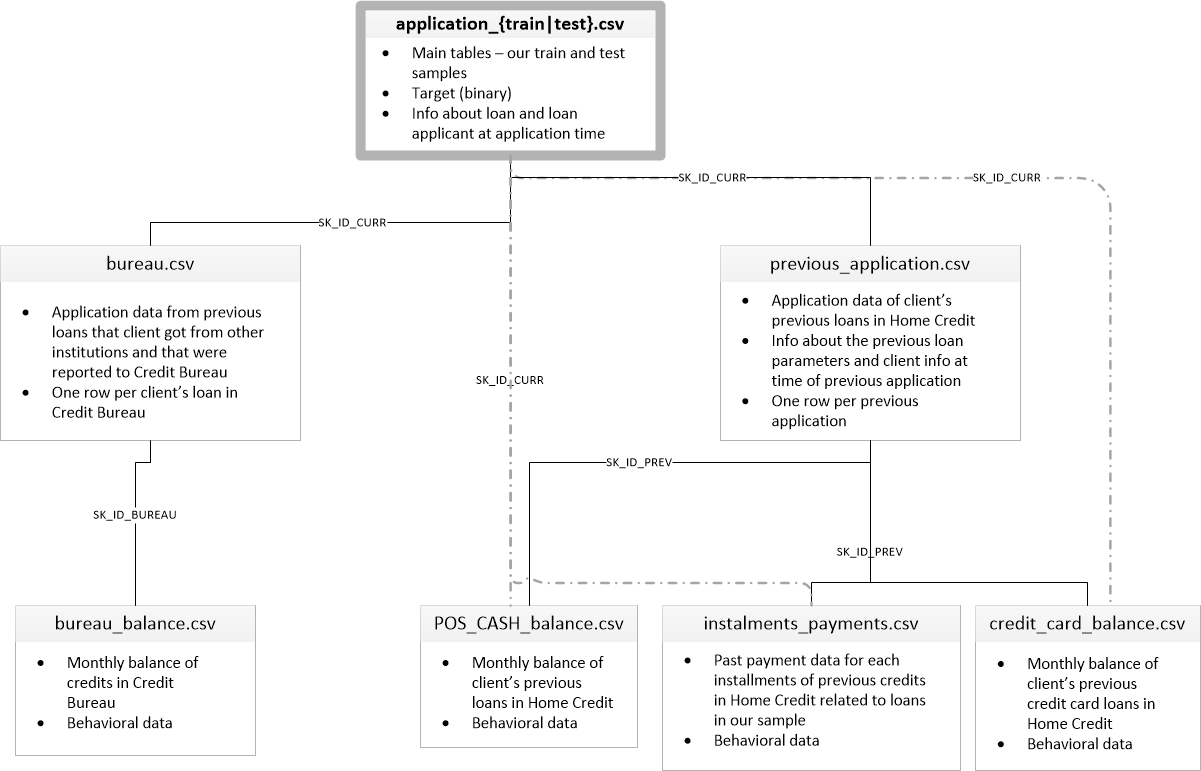

In [11]:
Image(filename='home_credit.png')

### Explore application_train (main table)

In [12]:
eda.data.application_train.shape

(307511, 122)

In [13]:
# TODO: to edawesome?
for el in eda.data.application_train.columns:
    print(el)

sk_id_curr
target
name_contract_type
code_gender
flag_own_car
flag_own_realty
cnt_children
amt_income_total
amt_credit
amt_annuity
amt_goods_price
name_type_suite
name_income_type
name_education_type
name_family_status
name_housing_type
region_population_relative
days_birth
days_employed
days_registration
days_id_publish
own_car_age
flag_mobil
flag_emp_phone
flag_work_phone
flag_cont_mobile
flag_phone
flag_email
occupation_type
cnt_fam_members
region_rating_client
region_rating_client_w_city
weekday_appr_process_start
hour_appr_process_start
reg_region_not_live_region
reg_region_not_work_region
live_region_not_work_region
reg_city_not_live_city
reg_city_not_work_city
live_city_not_work_city
organization_type
ext_source_1
ext_source_2
ext_source_3
apartments_avg
basementarea_avg
years_beginexpluatation_avg
years_build_avg
commonarea_avg
elevators_avg
entrances_avg
floorsmax_avg
floorsmin_avg
landarea_avg
livingapartments_avg
livingarea_avg
nonlivingapartments_avg
nonlivingarea_avg
apart

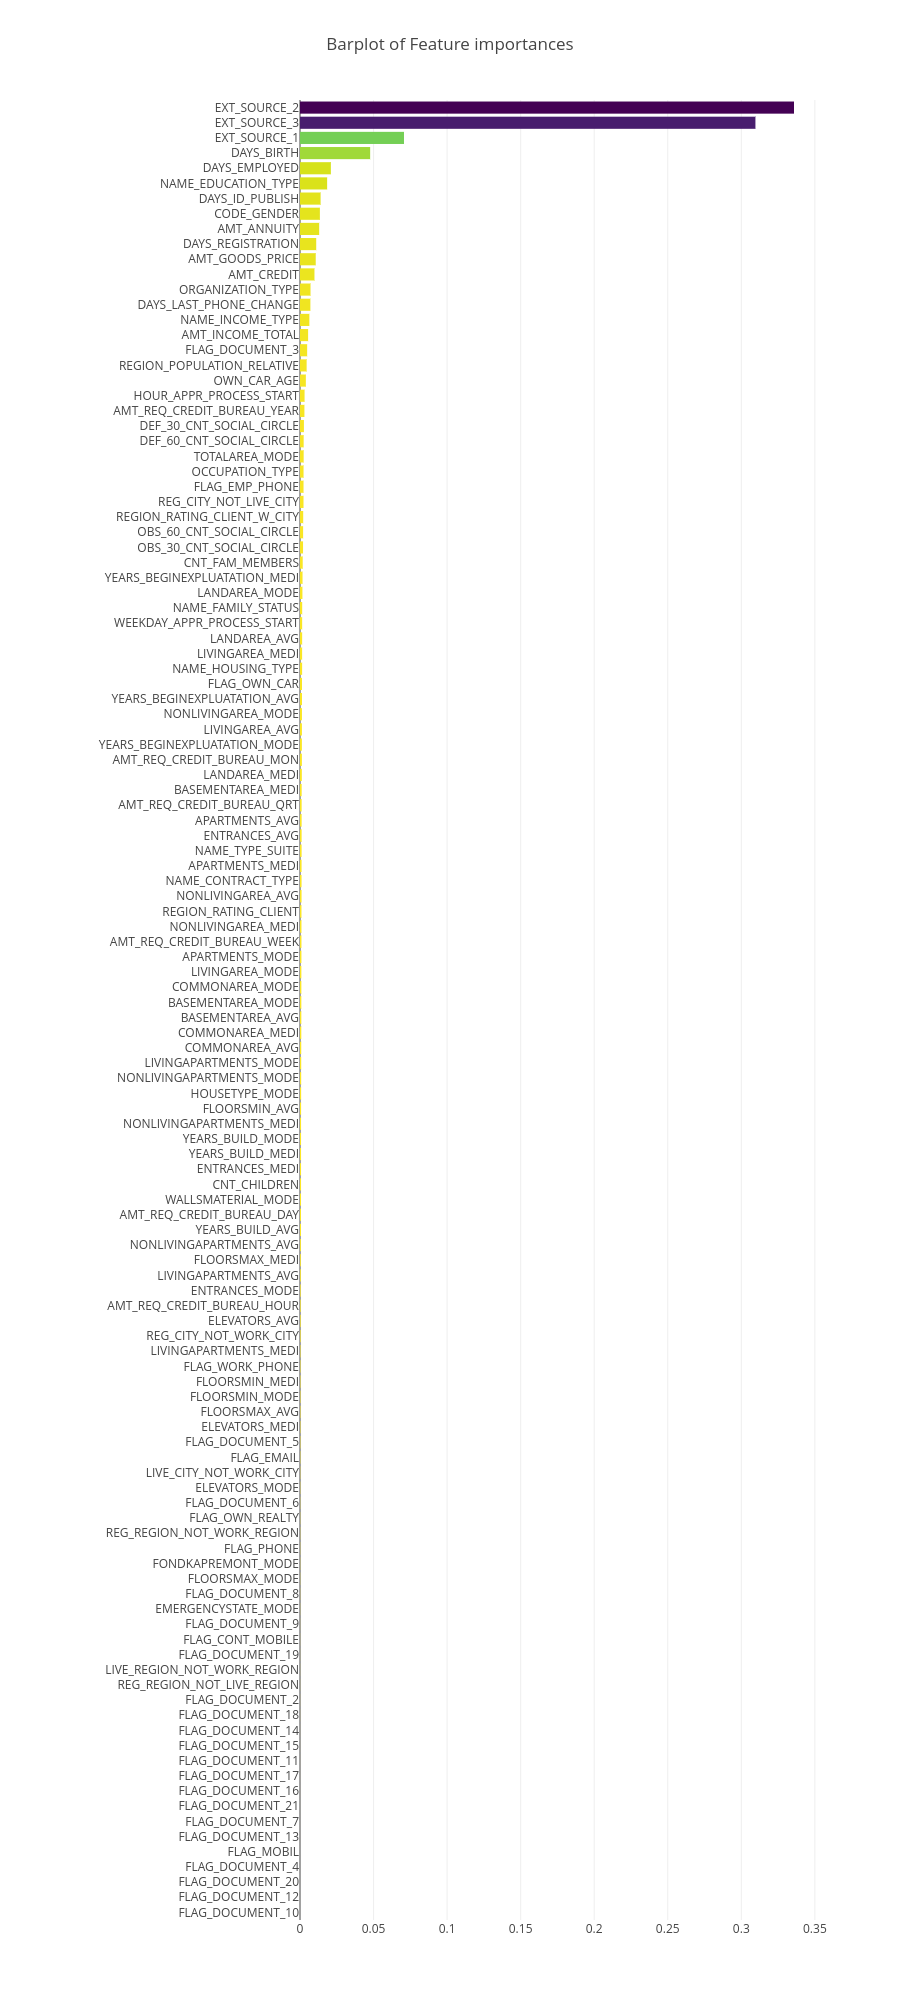

In [14]:
Image(filename='feature_importance.png')

[Feature importance with Random Forest](https://www.kaggle.com/code/codename007/home-credit-complete-eda-feature-importance)

The 3 variables with the strongest importance are EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3. According to the documentation, these features represent a "normalized score from external data source". I'm not sure what this exactly means, but it may be a cumulative sort of credit rating made using numerous sources of data.

In [15]:
ext_sources_df = eda.data.application_train[['ext_source_1', 'ext_source_2', 'ext_source_3', 'target']].to_pandas()

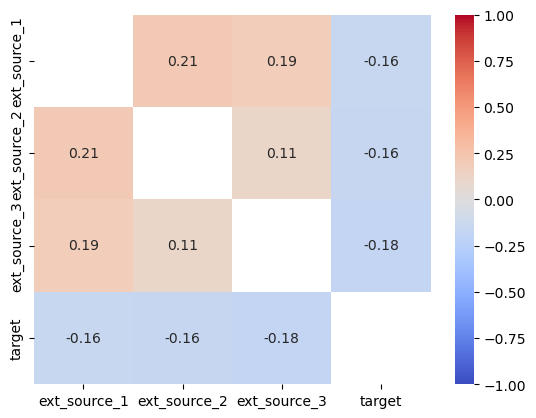

In [16]:
corr_heatmap(ext_sources_df, numeric_only=False)

All three EXT_SOURCE features have negative correlations with the target, indicating that as the value of the EXT_SOURCE increases, the client is more likely to repay the loan.

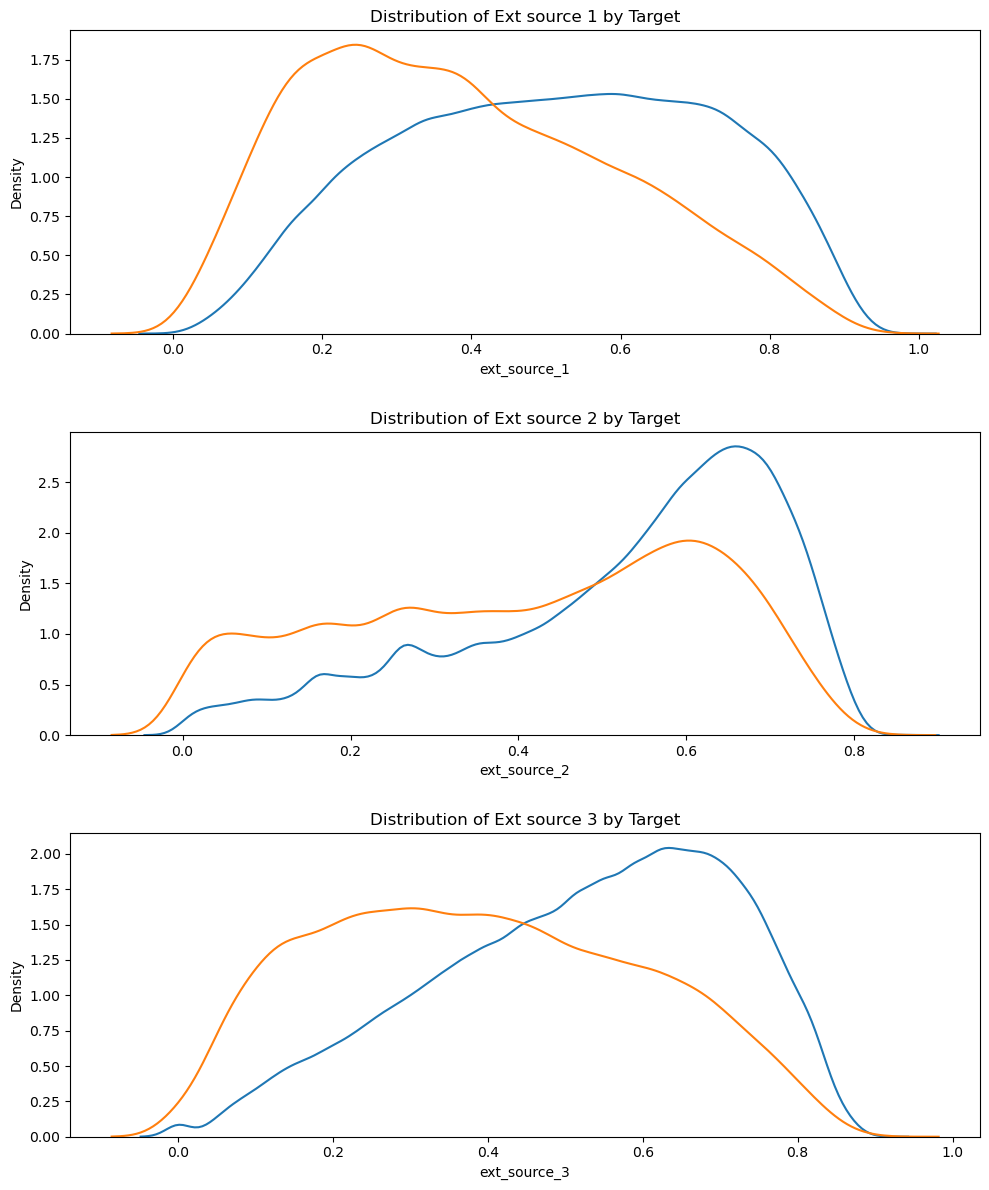

In [17]:
# TODO to edawesome - new style, which allows you to print density, not count?
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['ext_source_1', 'ext_source_2', 'ext_source_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(ext_sources_df.loc[ext_sources_df['target'] == 0, source])
    # plot loans that were not repaid
    sns.kdeplot(ext_sources_df.loc[ext_sources_df['target'] == 1, source])
    
    # Label the plots
    plt.title(f'Distribution of {snake_to_title(source)} by Target')
    plt.xlabel(f'{source}'); plt.ylabel('Density')
    
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3 displays the greatest difference between the values of the target. We can clearly see that this feature has some relationship to the likelihood of an applicant to repay a loan. The relationship is not very strong (in fact they are all considered very weak, but these variables will still be useful for a machine learning model to predict whether or not an applicant will repay a loan on time.

Let's proove that the EXT_SOURCE_3 mean is higher for loans that were repaid with statistical significance:

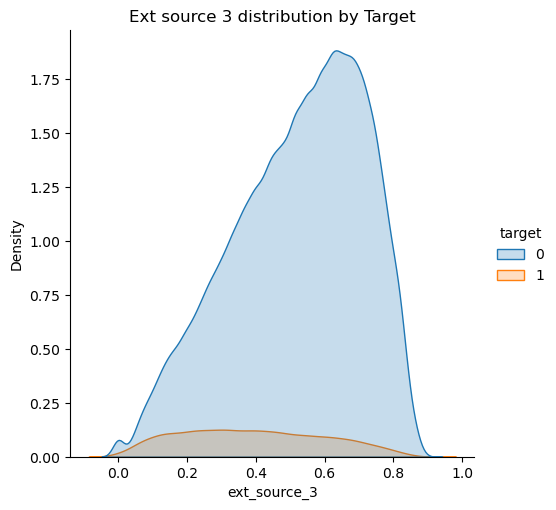

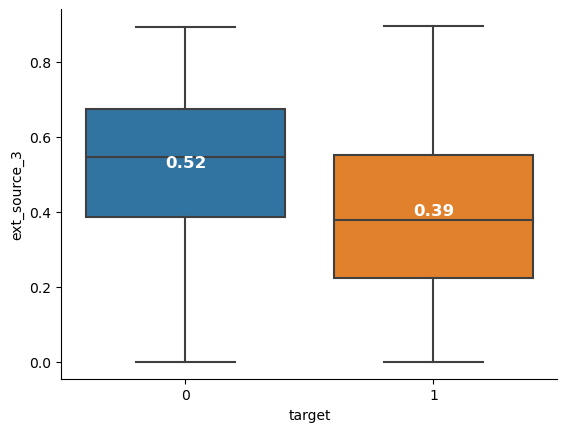

Compare means with t-test:
p-value: 0.0
Reject null hypothesis!


In [18]:
eda.compare_distributions('application_train', 'ext_source_3', 'target')

In [19]:
del ext_sources_df

### Features to predict

##### Loan repayment status

Obviously, we want to predict the TARGET variable, which is the loan repayment status: 0 - the loan was repaid, 1 - the loan was not repaid. Unfortunately, the dataset [is imbalanced](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction), so we need to take care of that.

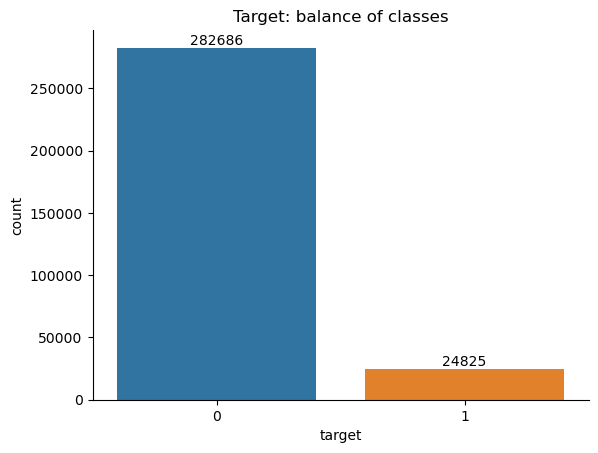

In [20]:
# fix eda.explore_ for pyspark
sns.countplot(
    data=eda.data.application_train.to_pandas(),
    x='target'
)

plt.bar_label(plt.gca().containers[0])
plt.title('Target: balance of classes')
sns.despine()
plt.show()

##### Risk score

We will predict average of 3 EXT SOURCE feautures or build multi-output regression model.

##### Reliability regarding the previous credits: credit_day_overdue, amt_credit_sum_overdue

We can predict overdue columns, based on general data about the client. Important to check, how long ago the previous credit was taken and use only the recent ones (otherwise, most of the information will be outdated).

In [21]:
amt_credit_sum_overdue_count = eda.data.bureau.amt_credit_sum_overdue.value_counts()
amt_credit_sum_overdue_count[:20]

0.0      1712270
4.5          301
9.0          107
13.5          81
18.0          72
22.5          60
45.0          56
27.0          52
36.0          50
31.5          48
54.0          41
40.5          40
58.5          33
675.0         32
49.5          31
72.0          29
67.5          28
148.5         28
63.0          28
90.0          28
Name: amt_credit_sum_overdue, dtype: int64

In [22]:
not_zero_count = amt_credit_sum_overdue_count[1:].sum()
not_zero_count

4158

In [23]:
not_zero_count / (not_zero_count + amt_credit_sum_overdue_count[0]) * 100

0.24224727165951615

These features are numerical, but have not so many values. This dataseet is **very imbalanced**. Most likely, it's impossible to predict the exact number of days or sum overdue, but we will try to predict, whether the client is overdue or not amd than just in case run regression model on top of classification.

It is also interesting to check the average overdue sum, compared to the credit sum.

Average not repaid sum:

In [24]:
not_repaid = eda.data.bureau.amt_credit_sum_overdue[eda.data.bureau.amt_credit_sum_overdue > 0].to_pandas()
not_repaid_mean = not_repaid.mean()
not_repaid_mean

15650.437456709957

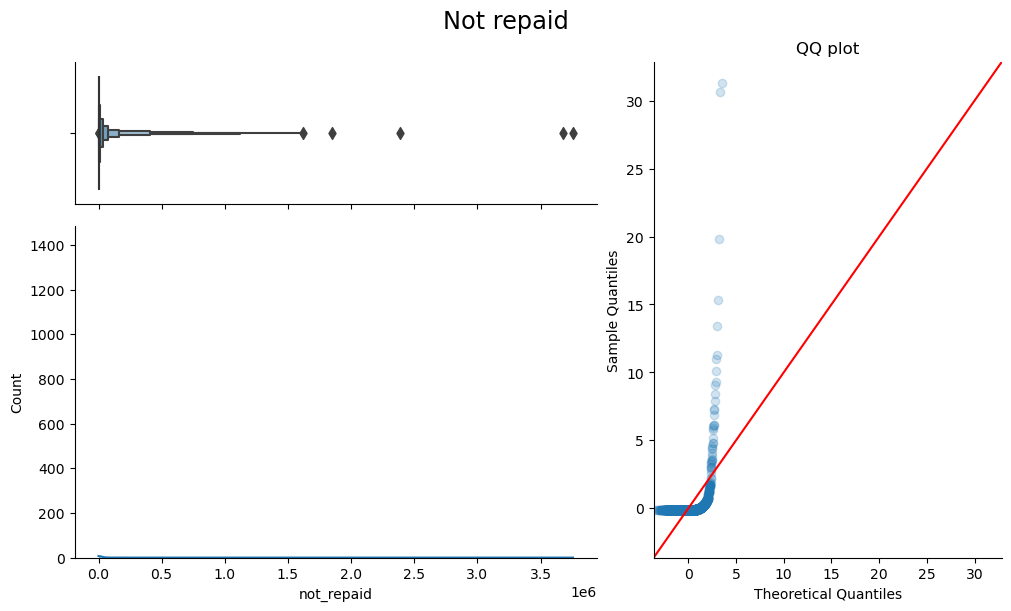

In [25]:
# TODO: fix edawesome (input not dataframe, but series)
kde_boxen_qq(
    pd.DataFrame({
        'not_repaid': not_repaid
    }), 'not_repaid'
)

In [26]:
cis = st.t.interval(0.95, len(not_repaid) - 1, not_repaid_mean, scale=st.sem(not_repaid))

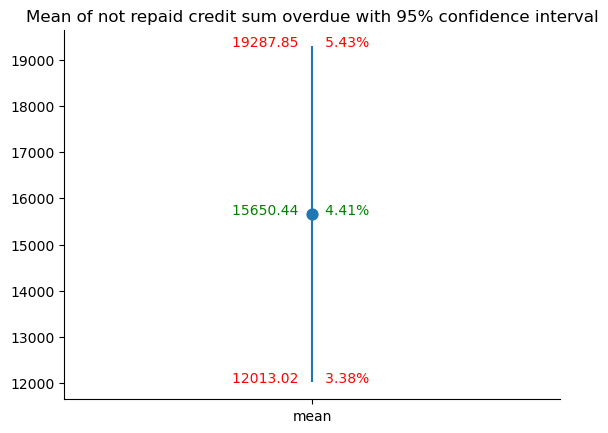

In [27]:
sns.pointplot(x=['mean'], y=[not_repaid_mean])
plt.errorbar(x=0, y=not_repaid_mean, yerr=cis[1] - not_repaid_mean, fmt='o')

# lavels for confidence interval
plt.text(x=0, y=cis[1], s=f'{cis[1]:.2f}   ', color='red', ha='right')
plt.text(x=0, y=cis[0], s=f'{cis[0]:.2f}   ', color='red', ha='right')
plt.text(x=0, y=not_repaid_mean, s=f'{not_repaid_mean:.2f}   ', color='green', ha='right')

mean_credit_amount = eda.data.bureau.amt_credit_sum.mean()
mean_percent = not_repaid_mean / mean_credit_amount

# labels for confidence interval taking into account mean credit amount
plt.text(x=0, y=not_repaid_mean, s=f'   {mean_percent:.2%}', color='green', ha='left')
plt.text(x=0, y=cis[1], s=f'   {cis[1] / mean_credit_amount:.2%}', color='red', ha='left')
plt.text(x=0, y=cis[0], s=f'   {cis[0] / mean_credit_amount:.2%}', color='red', ha='left')

plt.title('Mean of not repaid credit sum overdue with 95% confidence interval')

sns.despine()
plt.show()

**It turns out, that the average overdue sum is about 3.5% of the credit sum.**

### Features to train on

EXT SOURCE features are probably not available at the initial stage of the application (or we don't have this information at all), so we need to find some other features to train on for the initial stage model. We will use the following workflow:

1) Tune and the models on all the feautures (except EXT SOURCE), using subset of the data
2) Check the feature importance
3) Check documentation for most important features
4) Exclude some features and also classify the feautures, depending on their availability ((initial and second stage))
5) Re-train the models on the selected features

As a result, we will have several models for different stages of the application process with different sets of features.

Let us also check the gender feature, which has quite high importance:

In [28]:
pd.crosstab(eda.data.application_train.target.to_pandas(), eda.data.application_train.code_gender.to_pandas())

code_gender,F,M,XNA
target,,,
0,188278,94404,4
1,14170,10655,0


Females pay the loan more often... Probably, we cannot include this feature due to legal issues, so we should honestly inform the business about that and retrain the models if they don't want to use this feature.

# Custom metrics

**We will try to create such metrics, which show, how much money the business will lose, if we make a mistake.**

### Loan repayment status

We need to create a custom metric, which takes into account the amount of the loan.

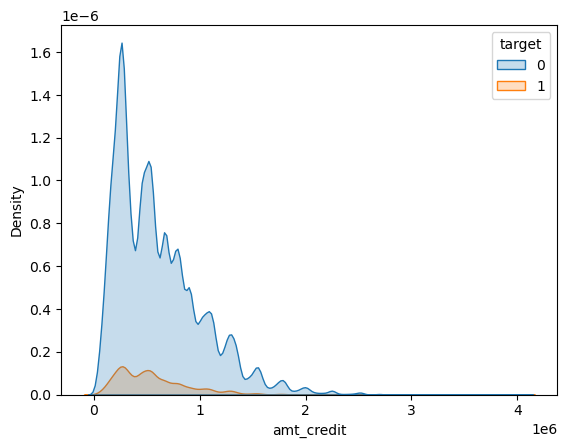

In [29]:
sns.kdeplot(eda.data.application_train[['amt_credit', 'target']].to_pandas(), x='amt_credit', hue='target', fill=True)
plt.show()

### Number of years to repay the loan

More years to repay the loan - more money the business will get from the interest.

In [30]:
eda.data.application_train['creadit_years'] = eda.data.application_train.amt_credit / eda.data.application_train.amt_annuity
creadit_years = eda.data.application_train['creadit_years'].to_pandas()

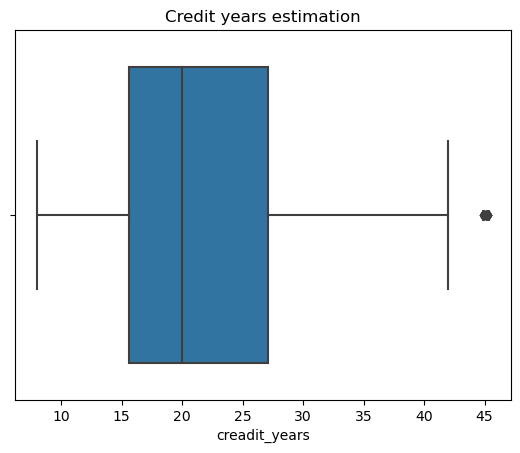

In [31]:
sns.boxplot(x=creadit_years)
plt.title('Credit years estimation')
plt.show()

**We will take into account interest rate and not paid rate (the ammount of money which is not repaid). It is also possible to take into account number of years in case of compound interest. We can adjust these values for the business needs.**

In [32]:
def custom_metric(true_class, predicted_class, amt_credit, interest_rate=0.1, not_paid_rate=0.9, decimal_places_num=6):

    if decimal_places_num > 6:
        raise ValueError('decimal_places_num must be less or equal to 6')

    # Is false positive
    # We predict a loan will be repaid, but it actually isn't repaid
    fp = (predicted_class == 0) & (true_class == 1)

    # Is false negative
    # We predict a loan won't be repaid, but it actually is repaid
    fn = (predicted_class == 1) & (true_class == 0)

    # Price of false positive error
    fp_cost = fp * amt_credit * not_paid_rate

    # Price of false negative error
    # Calculate compound interest for the whole credit period
    fn_cost = fn * amt_credit * interest_rate

    # Total cost
    total_cost = (fp_cost + fn_cost).sum()
    
    # Maximum total cost with dummy prediction, when we predict all loans will be repaid
    max_cost = ((true_class == 1) * amt_credit).sum() * not_paid_rate

    # Calculate the score and round it to maximum 6 decimal places
    # Rounding is needed to avoid not exact floating point calculations
    score = 1 / (1 + total_cost / max_cost)
    score = round(score, decimal_places_num)

    return score

In [33]:
df = eda.data.application_train[['target', 'amt_credit']].copy()
df['predicted_class'] = df.target

In [34]:
# Custom metric test: perfect prediction

perfect_score = custom_metric(df.target, df.predicted_class, df.amt_credit)
perfect_score

1.0

In [35]:
# Custom metric test: always positive prediction

df = eda.data.application_train[['target', 'amt_credit']].copy()
df['predicted_class'] = 1

always_positive_score = custom_metric(df.target, df.predicted_class, df.amt_credit)
always_positive_score


0.422472

In [36]:
# Custom metric test: always negative prediction

df = eda.data.application_train[['target', 'amt_credit']].copy()
df['predicted_class'] = 0

always_negative_score = custom_metric(df.target, df.predicted_class, df.amt_credit)
always_negative_score

0.5

In [37]:
assert perfect_score == 1
assert always_negative_score == 0.5

This metric is similar to f-score: 0.5 means that we are not better than stupid guessing, 1 means that we are perfect, minimum possible value is 0.

# Features preparation

### Loan repayment status and risk scores

In [38]:
eda._dataframes_dict.keys()

dict_keys(['homecredit_columns_description', 'pos_cash_balance', 'application_test', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'installments_payments', 'previous_application', 'sample_submission'])

In [39]:
eda.data.installments_payments.head()

,sk_id_prev,sk_id_curr,num_instalment_version,num_instalment_number,days_instalment,days_entry_payment,amt_instalment,amt_payment
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [40]:
dataframes = {
    'application_train': (eda.data.application_train, 'sk_id_curr'),
    'bureau': (eda.data.bureau, 'sk_id_bureau'),
    'previous_application': (eda.data.previous_application, 'sk_id_prev'),
    'installments_payments': (eda.data.installments_payments, 'sk_id_prev'),
}

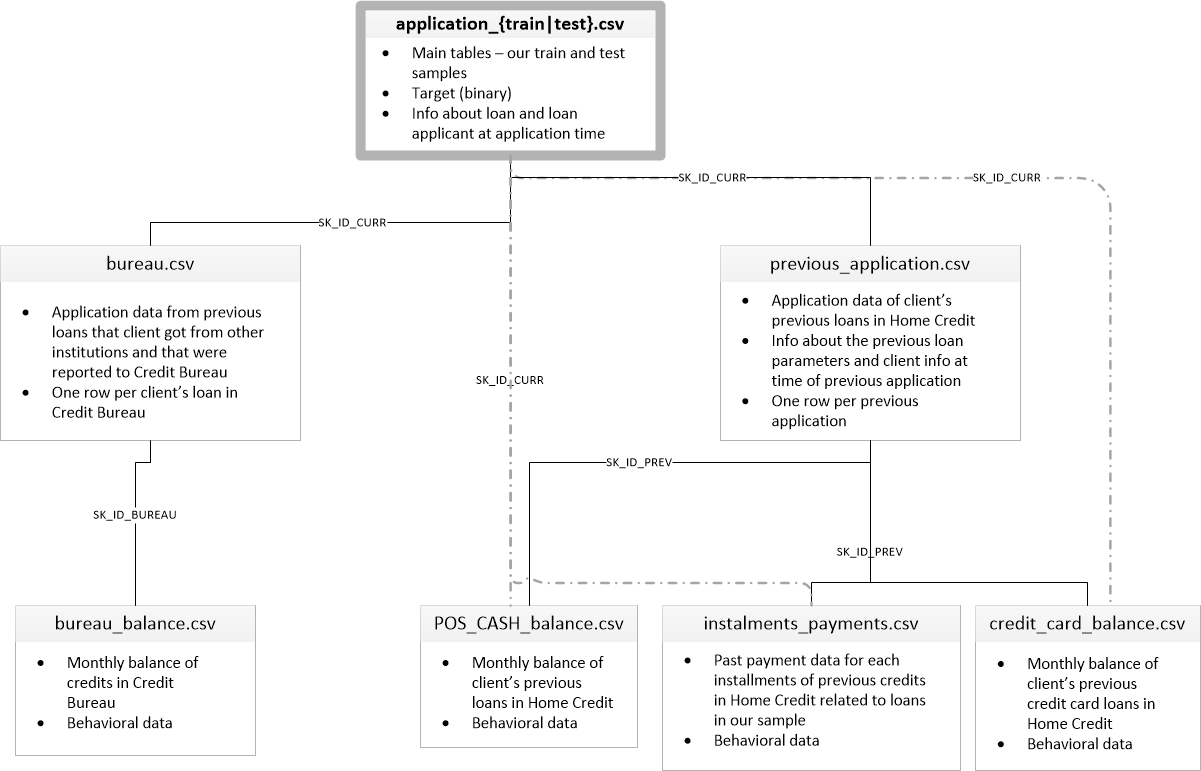

In [41]:
Image(filename='home_credit.png')

In [42]:
relationshps = {
    ('application_train', 'sk_id_curr', 'bureau', 'sk_id_curr'),
    ('application_train', 'sk_id_curr', 'previous_application', 'sk_id_curr'),
    ('application_train', 'sk_id_curr', 'installments_payments', 'sk_id_curr')
}

In [43]:
feature_matrix, feature_defs = ft.dfs(
    dataframes=dataframes,
    relationships=relationshps,
    target_dataframe_name='application_train'
)

In [44]:
shape = feature_matrix.shape
shape

(307511, 322)

In [ ]:
feature_matrix.spark.coalesce(1).to_csv('full_data')

In [ ]:
feature_matrix.sample(frac=0.1, random_state=SEED).spark.coalesce(1).to_csv('sampled_data')

In [46]:
# TODO: to edawesome
def downsample_majority_class_pandas(df, class_column):
    # Count the number of occurrences of each class
    class_counts = df[class_column].value_counts()

    # Identify the majority and minority classes
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()

    # Separate the majority and minority classes into separate dataframes
    majority_class_df = df.loc[df[class_column] == majority_class]
    minority_class_df = df.loc[df[class_column] == minority_class]

    # Downsample the majority class by randomly selecting a subset of rows
    downsampled_majority_class_df = majority_class_df.sample(n=len(minority_class_df), random_state=42)

    # Concatenate the downsampled majority class dataframe with the minority class dataframe
    downsampled_df = pd.concat([downsampled_majority_class_df, minority_class_df])

    return downsampled_df

In [47]:
def downsample_majority_class_pyspark(df, class_column):
    # Count the number of occurrences of each class
    class_counts = df.select(class_column).groupby(class_column).agg(count(class_column))

    # Identify the majority and minority classes
    majority_class = class_counts.sort(count(class_column).desc()).first()[0]
    minority_class = class_counts.sort(count(class_column).asc()).first()[0]

    # Separate the majority and minority classes into separate dataframes
    majority_class_df = df.filter(col(class_column) == majority_class)
    minority_class_df = df.filter(col(class_column) == minority_class)

    # Downsample the majority class by randomly selecting a subset of rows
    downsampled_majority_class_df = majority_class_df.sample(False, 1.0 * minority_class_df.count() / majority_class_df.count())

    # Concatenate the downsampled majority class dataframe with the minority class dataframe
    downsampled_df = downsampled_majority_class_df.union(minority_class_df)

    return downsampled_df


In [48]:
def downsample_majority_class(df, class_column):

    if isinstance(df, pd.DataFrame):
        return downsample_majority_class_pandas(df, class_column)

    elif isinstance(df, pyspark.sql.DataFrame):
        return downsample_majority_class_pyspark(df, class_column)

    elif isinstance(df, pyspark.pandas.frame.DataFrame):
        return pyspark.pandas.DataFrame(downsample_majority_class_pyspark(df.to_spark(), class_column))
        
    else:
        raise ValueError('df must be either pandas or pyspark DataFrame')

In [ ]:
downsampled_feature_matrix = downsample_majority_class(feature_matrix, 'target')

Exception in thread "serve-DataFrame" java.net.SocketTimeoutException: Accept timed out
	at java.base/sun.nio.ch.NioSocketImpl.timedAccept(NioSocketImpl.java:708)
	at java.base/sun.nio.ch.NioSocketImpl.accept(NioSocketImpl.java:752)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:675)
	at java.base/java.net.ServerSocket.platformImplAccept(ServerSocket.java:641)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:617)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:574)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:532)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:64)


In [ ]:
downsampled_feature_matrix.spark.coalesce(1).to_csv('downsampled_data')

### Reliability regarding the previous credits

In [ ]:
eda.data.bureau.spark.coalesce(1).to_csv('full_bureau_data')

### Not treated features

In [50]:
eda.not_treated_features

['table',
 'row',
 'description',
 'special',
 'name_contract_status',
 'name_type_suite',
 'name_income_type',
 'name_housing_type',
 'occupation_type',
 'weekday_appr_process_start',
 'organization_type',
 'wallsmaterial_mode',
 'status',
 'name_contract_status']

In [51]:
not_treated = tuple(set(eda.not_treated_features).intersection(set(feature_matrix.columns)))
not_treated

('name_income_type',
 'name_type_suite',
 'occupation_type',
 'organization_type',
 'weekday_appr_process_start',
 'wallsmaterial_mode',
 'name_housing_type')

In [52]:
for el in not_treated:
    print(el)
    col_count = feature_matrix[el].value_counts()
    display(col_count.head())
    print(f'Number of unique values: {len(col_count)}')
    print('-------------------------')

name_income_type


Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Name: name_income_type, dtype: int64

Number of unique values: 8
-------------------------
name_type_suite


Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Name: name_type_suite, dtype: int64

Number of unique values: 7
-------------------------
occupation_type


Laborers       55186
Sales staff    32102
Core staff     27570
Managers       21371
Drivers        18603
Name: occupation_type, dtype: int64

Number of unique values: 18
-------------------------
organization_type


Business Entity Type 3    67992
XNA                       55374
Self-employed             38412
Other                     16683
Medicine                  11193
Name: organization_type, dtype: int64

Number of unique values: 58
-------------------------
weekday_appr_process_start


TUESDAY      53901
WEDNESDAY    51934
MONDAY       50714
THURSDAY     50591
FRIDAY       50338
Name: weekday_appr_process_start, dtype: int64

Number of unique values: 7
-------------------------
wallsmaterial_mode


Panel           66040
Stone, brick    64815
Block            9253
Wooden           5362
Mixed            2296
Name: wallsmaterial_mode, dtype: int64

Number of unique values: 7
-------------------------
name_housing_type


House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Name: name_housing_type, dtype: int64

Number of unique values: 6
-------------------------


Actually, it makes sense to tokenixe and cluster only `occupation_type` and `organization_type` columns, other columns are categorical and don't have so many values. Let's save this information:

In [53]:
not_treated = ('occupation_type', 'organization_type')

In [ ]:
with open('not_treated.pickle', 'wb') as f:
    pickle.dump(not_treated, f)